# Log Probabilities

In [1]:
%load_ext autoreload
%autoreload 2
!pip install --quiet score_models colorcet SciencePlots tqdm # For colab notebooks.
from score_models.plot_utils import *
from score_models.toy_distributions import *
from torch.func import grad, vmap
from torch import nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

/home/alexandre/anaconda3/envs/caustic/lib/python3.9/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
from score_models import MLP, ScoreModel, HessianDiagonal, VESDE

In [3]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, distribution, batch_size):
        self.distribution = distribution
        self.batch_size = batch_size

    def __len__(self):
        return 1000

    def __getitem__(self, idx):
        return self.distribution.sample((self.batch_size,))

In [4]:
B = int(2**8)
distribution = egg_box(modes=4, mode_width=0.3, box_size=1.0, weights=(1., 0.5, 0.3, 0.1))
dataset = Dataset(distribution, B)

## Probability Flow ODE

## Training a Hessian diagonal model

### SBM

In [4]:
net = MLP(2, width=100, layers=4)
sde = VESDE(sigma_min=1e-2, sigma_max=5)
sbm = ScoreModel(net, sde)
sbm.fit(dataset, epochs=20, lr=1e-3);

### HDM

In [15]:
hnet = MLP(2, width=100, layers=4)
hdm = HessianDiagonal(sbm, hnet)
hdm.fit(dataset, epochs=20, lr=1e-3);

Score model weights are now frozen. This class does not currently support joint optimization.
No path provided. Training checkpoints will not be saved.


Epoch 20 | Cost: 1.5e+00 |: 100%|██████████| 20/20 [02:51<00:00,  8.60s/it]

Finished training after 0.048 hours.


In [16]:
def logp(x):
    return distribution.log_prob(x)

def sbm_logp(x):
    return sbm.log_prob(x, steps=40)
/
def hessian_logp(x):
    return hdm.log_prob(x, steps=40)

t=1 | sigma=4 | x=1±6: 100%|██████████| 40/40 [00:07<00:00,  5.40it/s]         
t=1 | sigma=4 | x=1±6: 100%|██████████| 40/40 [00:05<00:00,  6.80it/s]         


Text(0.5, 1.0, 'Hessian model')

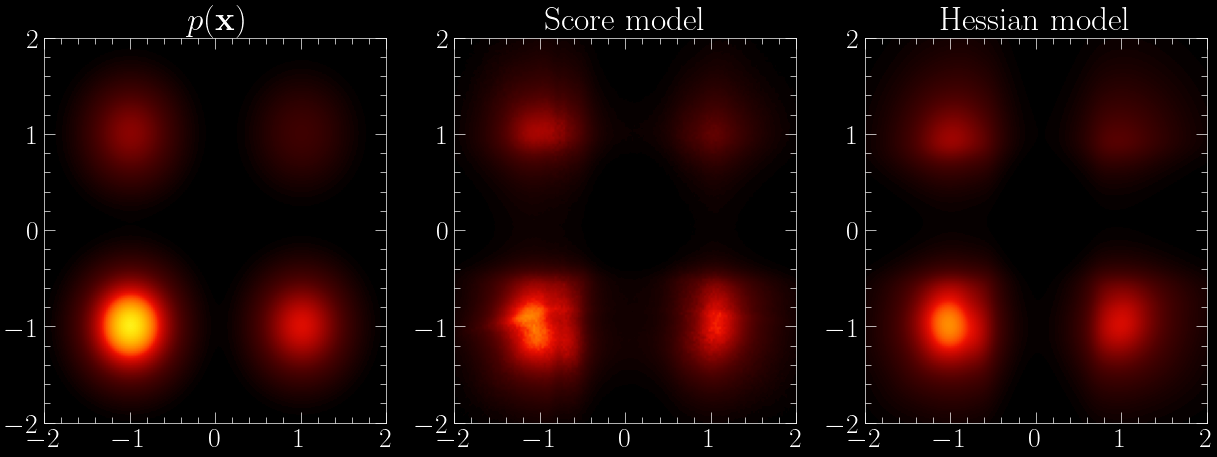

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
vmax = 1
vmin = 0

ax = axs[0]
plot_density(logp, ax=ax, vmin=vmin, vmax=vmax)
ax.set_title(r"$p(\mathbf{x})$")

ax = axs[1]
plot_density(sbm_logp, ax=ax, vmin=vmin, vmax=vmax)
ax.set_title("Score model")

ax = axs[2]
plot_density(hessian_logp, ax=ax, vmin=vmin, vmax=vmax)
ax.set_title("Hessian model");

## Joint second order optimization

In [6]:
# Initialize SBM
net = MLP(2, width=100, layers=4)
sde = VESDE(sigma_min=1e-2, sigma_max=5)
sbm = ScoreModel(net, sde)
# Intialize HDM
hnet = MLP(2, width=100, layers=4)
hdm = HessianDiagonal(sbm, hnet, loss="joint", second_order_weight=0.5)
# Jointly train SBM and HDM
losses = hdm.fit(dataset, epochs=40, lr=1e-3);

No path provided. Training checkpoints will not be saved.


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 40 | Cost: 1.2e+00 |: 100%|██████████| 40/40 [07:53<00:00, 11.83s/it]

Finished training after 0.131 hours.


In [7]:
def logp(x):
    return distribution.log_prob(x)
        
def sbm_logp(x):
    return sbm.log_prob(x, steps=40)
/
def hessian_logp(x):
    return hdm.log_prob(x, steps=40)

t=1 | sigma=4 | x=1±7: 100%|██████████| 40/40 [00:07<00:00,  5.69it/s]         
t=1 | sigma=4 | x=1±7: 100%|██████████| 40/40 [00:04<00:00,  8.58it/s]         


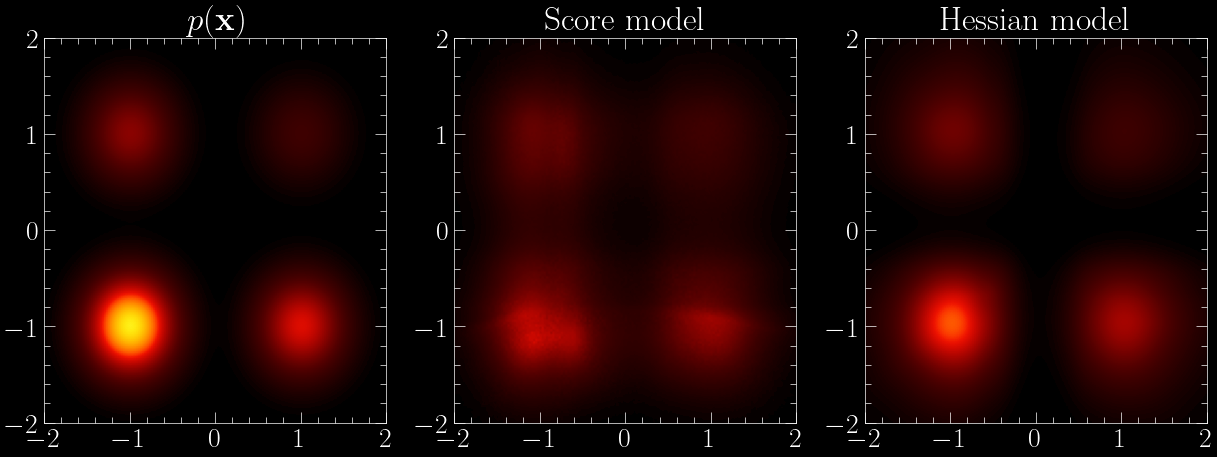

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
vmax = 1
vmin = 0

ax = axs[0]
plot_density(logp, ax=ax, vmin=vmin, vmax=vmax)
ax.set_title(r"$p(\mathbf{x})$")

ax = axs[1]
plot_density(sbm_logp, ax=ax, vmin=vmin, vmax=vmax)
ax.set_title("Score model")

ax = axs[2]
plot_density(hessian_logp, ax=ax, vmin=vmin, vmax=vmax)
ax.set_title("Hessian model");